# TSML (Time Series Machine Learning)
- **Speaker:  Paulito Palmes**
- **IBM Dublin Research Lab**
- July 23, 2019

## Motivations
- innovations in industry sectors brought automations 
- automations require installation of sensor networks 
- main challenges:
  - collect large volume of data, detect anomalies, monitor status
  - discover patterns to reduce downtimes and manufacturing errors
  - reduce energy usage
  - predict faults/failures
  - effective maintenance schedules

_TSML leverages AI and ML libraries from ScikitLearn, Caret, and Julia as building blocks for processing huge amount of industrial time series data._

## Typical TSML Workflow

## First, let's create an artificial data with missing values

In [2]:
using DataFrames
using Dates
using Random
ENV["COLUMNS"]=1000 # for dataframe column size
using TSML: fit, fit!, transform, transform!
using Plots

function generateXY()
    Random.seed!(123)
    gdate = DateTime(2014,1,1):Dates.Minute(15):DateTime(2014,1,5)
    gval = Array{Union{Missing,Float64}}(rand(length(gdate)))
    gmissing = floor(0.30*length(gdate)) |> Integer
    gndxmissing = Random.shuffle(1:length(gdate))[1:gmissing]
    X = DataFrame(Date=gdate,Value=gval)
    X.Value[gndxmissing] .= missing
    Y = rand(length(gdate))
    (X,Y)
end;
(df,outY)=generateXY(); first(df,10)

[ Info: Precompiling TSML [198dc43e-9e51-5cd7-9d40-d9794d335912]


Row,Date,Value
,DateTime,Float64?
1,2014-01-01T00:00:00,0.9063
2,2014-01-01T00:15:00,0.443494
3,2014-01-01T00:30:00,0.745673
4,2014-01-01T00:45:00,0.512083
5,2014-01-01T01:00:00,missing
6,2014-01-01T01:15:00,0.334152
7,2014-01-01T01:30:00,missing
8,2014-01-01T01:45:00,missing
9,2014-01-01T02:00:00,0.0991336


## Let's load the TSML modules and filters to process data

In [3]:
using TSML

## Let's use Pipeline with Plotter filter to plot artificial data

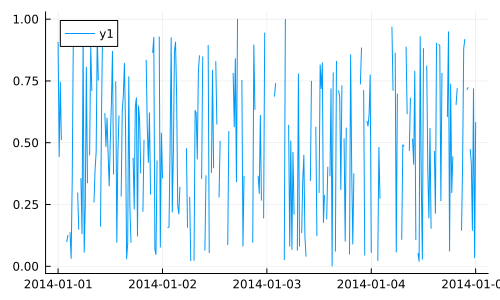

In [6]:
pltr=Plotter(Dict(:interactive => true))

mypipeline = pltr

fit_transform!(mypipeline, df);

## Let's get the statistics/data quality including blocks of missing data

In [8]:
statfier = Statifier(Dict(:processmissing=>false))

mypipeline = statfier

fit_transform!(mypipeline, df)

Row,tstart,tend,sfreq,count,max,min,median,mean,q1,q2,q25,q75,q8,q9,kurtosis,skewness,variation,entropy,autocor,pacf
,DateTime,DateTime,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014-01-01T00:00:00,2014-01-05T00:00:00,0.249351,270,0.999721,0.000981938,0.47879,0.481656,0.0787459,0.157719,0.230357,0.728315,0.778832,0.883753,-1.22101,0.0106693,0.602218,67.6642,0.25577,0.275333


## Let's extend the Pipeline workflow with aggregate, impute, and plot 

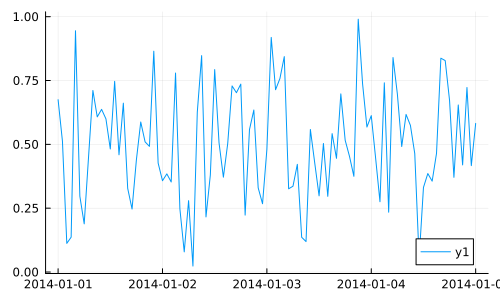

In [10]:
valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))

mypipeline = valgator |> pltr

fit_transform!(mypipeline, df);

## Let's now try real data

In [11]:
fname = joinpath(dirname(pathof(TSML)),"../data/testdata.csv")
csvreader = CSVDateValReader(Dict(:filename=>fname,:dateformat=>"dd/mm/yyyy HH:MM"))

outputname = joinpath(dirname(pathof(TSML)),"/tmp/testdata_output.csv")
csvwriter = CSVDateValWriter(Dict(:filename=>outputname))

valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valputer = DateValLinearImputer(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))
outliernicer = Outliernicer(Dict(:dateinterval=>Dates.Hour(1)));

## Let's plot the real data and check for missing values

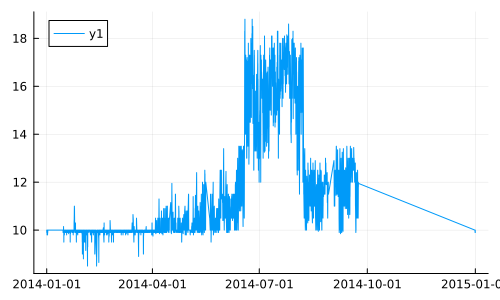

In [13]:
mpipeline1 = csvreader |> valgator |> pltr

fit_transform!(mpipeline1);

## Let's get the statistics to assess data quality

In [14]:
mpipeline1 = csvreader |> valgator |> stfier 

fit_transform!(mpipeline1)

Row,tstart,tend,sfreq,count,max,min,median,mean,q1,q2,q25,q75,q8,q9,kurtosis,skewness,variation,entropy,autocor,pacf,bmedian,bmean,bq25,bq75,bmin,bmax
,DateTime,DateTime,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014-01-01T00:00:00,2014-12-31T15:00:00,0.998859,3830,18.8,8.5,10.35,11.557,9.9,10.0,10.0,12.3,13.0,16.0,0.730635,1.41283,0.200055,-1.09145e5,4.39315,1.04644,4931.0,4931.0,4931.0,4931.0,4931.0,4931.0


## Let's try imputing and verify the statistical features

In [15]:
mpipeline2 = csvreader |> valgator |> valputer |> statfier

fit_transform!(mpipeline2)

Row,tstart,tend,sfreq,count,max,min,median,mean,q1,q2,q25,q75,q8,q9,kurtosis,skewness,variation,entropy,autocor,pacf
,DateTime,DateTime,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2014-01-01T00:00:00,2014-12-31T15:00:00,0.998859,8761,18.8,8.5,9.9,10.6244,9.9,9.9,9.9,10.0,10.5,12.5,6.67036,2.7373,0.163356,-2.21059e5,4.50868,1.05318


## Let's visualize the imputted data

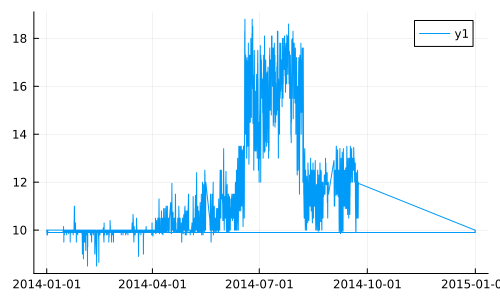

In [17]:
mpipeline2 = csvreader |> valgator |> valputer |> pltr

fit_transform!(mpipeline2);

## Let's have examples of Monotonic data

In [18]:
regularfile = joinpath(dirname(pathof(TSML)),"../data/typedetection/regular.csv")
monofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/monotonic.csv")
dailymonofile = joinpath(dirname(pathof(TSML)),"../data/typedetection/dailymonotonic.csv")

regularfilecsv = CSVDateValReader(Dict(:filename=>regularfile,:dateformat=>"dd/mm/yyyy HH:MM"))
monofilecsv = CSVDateValReader(Dict(:filename=>monofile,:dateformat=>"dd/mm/yyyy HH:MM"))
dailymonofilecsv = CSVDateValReader(Dict(:filename=>dailymonofile,:dateformat=>"dd/mm/yyyy HH:MM"))

valgator = DateValgator(Dict(:dateinterval=>Dates.Hour(1)))
valputer = DateValLinearImputer(Dict(:dateinterval=>Dates.Hour(1)))
stfier = Statifier(Dict(:processmissing=>true))
mononicer = Monotonicer(Dict())
stfier = Statifier(Dict(:processmissing=>true))
outliernicer = Outliernicer(Dict(:dateinterval=>Dates.Hour(1)));

## Let's plot an example of monotonic data

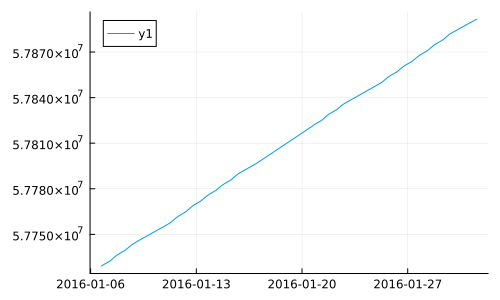

In [20]:
monopipeline = monofilecsv |> valgator  |> pltr

fit_transform!(monopipeline);

## Let's plot after normalizing the monotonic data

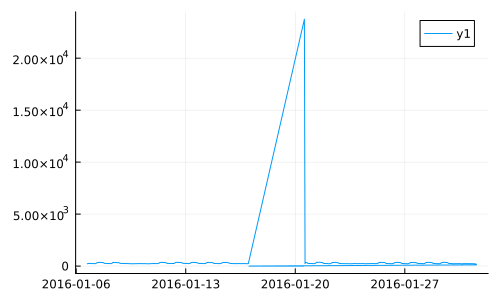

In [22]:
monopipeline = monofilecsv |> valgator |> valputer |> mononicer |> pltr

fit_transform!(monopipeline);

## Let's remove outliers and plot the result

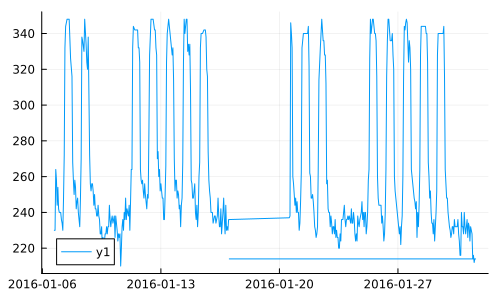

In [24]:
monopipeline = monofilecsv |> valgator |> valputer|> mononicer |> outliernicer |> pltr

fit_transform!(monopipeline);

## Let's plot and example of a daily monotonic data

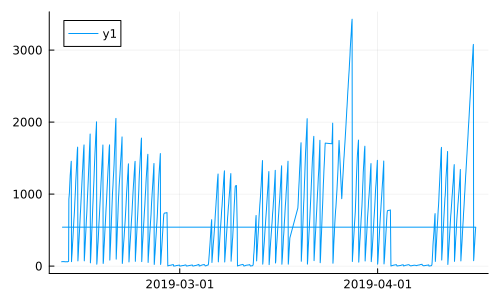

In [26]:
dailymonopipeline = dailymonofilecsv |> valgator |> valputer |> pltr

fit_transform!(dailymonopipeline);

## Let's normalize and plot

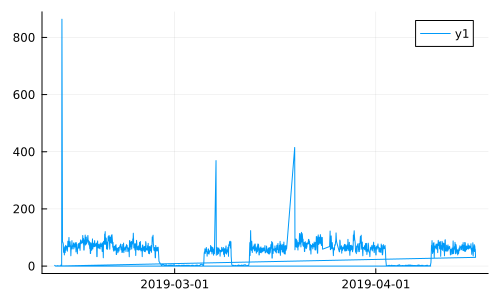

In [28]:
dailymonopipeline = dailymonofilecsv |> valgator |> valputer |> mononicer |> pltr
    
fit_transform!(dailymonopipeline);

## Let's add the Outliernicer filter and plot

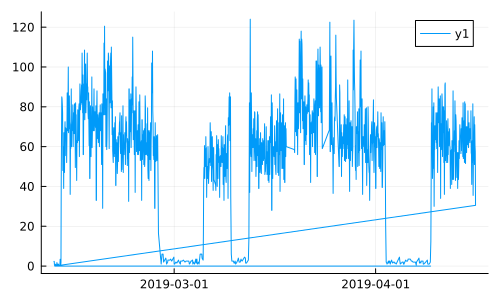

In [34]:
dailymonopipeline = dailymonofilecsv |> valgator |> valputer |> mononicer |> outliernicer |> pltr

fit_transform!(dailymonopipeline);

## Let's use what we have learned so far to perform automatic data type classification

In [35]:
using TSML: TSClassifier
Random.seed!(12)

trdirname = joinpath(dirname(pathof(TSML)),"../data/realdatatsclassification/training")
tstdirname = joinpath(dirname(pathof(TSML)),"../data/realdatatsclassification/testing")
modeldirname = joinpath(dirname(pathof(TSML)),"../data/realdatatsclassification/model")

tscl = TSClassifier(Dict(:trdirectory=>trdirname,
           :tstdirectory=>tstdirname,
           :modeldirectory=>modeldirname,
           :feature_range => 6:20,
           :num_trees=>50)
)

fit!(tscl)
dfresults = transform!(tscl);
apredict = dfresults.predtype
fnames = dfresults.fname
myregex = r"(?<dtype>[A-Z _ - a-z]+)(?<number>\d*).(?<ext>\w+)"
mtypes=map(fnames) do fname
  mymatch=match(myregex,fname)
  mymatch[:dtype]
end

sum(mtypes .== apredict)/length(mtypes) * 100 |> x-> round(x,digits=2)

getting stats of AirOffTemp1.csv
getting stats of AirOffTemp2.csv
getting stats of AirOffTemp3.csv
getting stats of Energy1.csv
getting stats of Energy10.csv
getting stats of Energy2.csv
getting stats of Energy3.csv
getting stats of Energy4.csv
getting stats of Energy6.csv
getting stats of Energy7.csv
getting stats of Energy8.csv
getting stats of Energy9.csv
getting stats of Pressure1.csv
getting stats of Pressure3.csv
getting stats of Pressure4.csv
getting stats of Pressure6.csv
getting stats of RetTemp11.csv
skipping RetTemp21.csv: ErrorException("Nearest Neigbour algo failed to replace missings")
skipping RetTemp41.csv: ErrorException("Nearest Neigbour algo failed to replace missings")
getting stats of RetTemp51.csv
getting stats of AirOffTemp4.csv
getting stats of AirOffTemp5.csv
getting stats of Energy5.csv
getting stats of Pressure5.csv
skipping RetTemp31.csv: ErrorException("Nearest Neigbour algo failed to replace missings")
loading model from file: /Users/ppalmes/phome/julia/TS

75.0

## TSML features
- TS data type clustering/classification for automatic data discovery
- TS aggregation based on date/time interval
- TS imputation based on symmetric Nearest Neighbors
- TS statistical metrics for data quality assessment
- TS ML wrapper with more than 100+ libraries from caret, scikitlearn, and julia
- TS date/value matrix conversion of 1-D TS using sliding windows for ML input

## More TSML features
- Common API wrappers for ML libs from JuliaML, PyCall, and RCall
- Pipeline API allows high-level description of the processing workflow
- Specific cleaning/normalization workflow based on data type
- Automatic selection of optimised ML model
- Automatic segmentation of time-series data into matrix form for ML training and prediction
- Easily extensible architecture by using just two main interfaces: fit and transform
- Meta-ensembles for robust prediction
- Support for distributed computation, for scalability, and speed